In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import src.utils.globals as g

sys.path.append(os.path.abspath('../src'))
import anomalydetectors as m        # type: ignore
import aggregators as agg           # type: ignore
from experiment import Experiment   # type: ignore
from noise import NoiseFactory      # type: ignore
from plotting import plot_rpcurves  # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def run_experiment(df : pd.DataFrame, models, columns, name, robotsids = []):
    df['anomalous'] = df['anomaly_syn_type'] != ""
    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, (['seqid', 'timeindex_bin'], columns), spliton="robotid", verbose=True)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(aggrfunc=agg.aggr_sum)

    experiment.pickle()

    return experiment


def name_experiment(prefix, ratio, intensity, robotids):
    name = f"{prefix}_{ratio}_{intensity}"

    if robotids:
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    return name

def name_guassian_experiment(ratio, intensity, robotids):
    return name_experiment("gaussian", ratio, intensity, robotids)

def name_sinusoidal_experiment(ratio, intensity, robotids):
    return name_experiment("sinusoidal", ratio, intensity, robotids)

def name_point_experiment(ratio, intensity, robotids):
    return name_experiment("point", ratio, intensity, robotids)

def run_gaussian_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = name_guassian_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.gaussian(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = name_sinusoidal_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.sinusoidal(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_point_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name =  name_point_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.point(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

In [3]:
df_in = pd.read_parquet(os.getcwd() + "/" + g.path_tracks)

In [6]:
# Boolean whether to run the experiments or load
load_experiments = True

# Running Experiment Parameters
models = [m.ZScore(), m.MZScore(), m.LOF(), m.IF()]
exp_columns = ['torqueactual']
syn_column = 'torqueactual'

guassian_params     = [0.10, 0.25, 0.40, 0.55]
guassian_column_length = len(guassian_params)

sinusoidal_params   = [0.25, 0.5, 1, 2]
sinusoidal_column_length = len(sinusoidal_params)

point_params        = [1, 5, 10, 100]
point_column_length = len(point_params)

ids = ['6640-102140-1']
synratio = 0.1

# Loading Experiment Parameters


In [5]:
def load_or_run_experiments(params, name_func, run_func):
    experiments = {}
    if load_experiments:
        for intensity in params:
            name = name_func(synratio, intensity, ids)
            print(f"Loading Experiment {name}")        
            experiments[name] = Experiment.unpickle(name)
        print("Experiments Loaded")
    else:
        for intensity in params:
            print(f"Running Experiment {name_func.__name__.split('_')[1]} {intensity}")
            exp = run_func(df_in, models, exp_columns, syn_column, synratio, intensity, robotids=ids)
            experiments[exp.name] = exp   
        print("Finished Running Experiments")
    return experiments

# GAUSSIAN

In [7]:
exps_gaussian = load_or_run_experiments(guassian_params, name_guassian_experiment, run_gaussian_experiment)


Loading Experiment gaussian_0.1_0.1_6640-102140-1
Loading Experiment gaussian_0.1_0.25_6640-102140-1
Loading Experiment gaussian_0.1_0.4_6640-102140-1
Loading Experiment gaussian_0.1_0.55_6640-102140-1
Experiments Loaded


In [8]:
def _plot_experiments(exp, methodname, ax, id=None):
    ## Calculate the best threshold (by F1 score) for the model
    precision, recall, thresholds = exp.results['pr'][methodname]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    print(best_threshold)

    ##
    ax2 = ax.twinx()

    df = exp.results['df'].sort_values(by='timeindex')
    df = df[df['seqid'] == id]

    ax.plot(df['timeindex'], df['torqueactual'], label="Torque")

    df_below = df[df[methodname] <= best_threshold]
    df_above = df[df[methodname] > best_threshold]
    ax2.scatter(df_below['timeindex'], abs(df_below[methodname]), label=f'{methodname} score', color='green', s=2)
    ax2.scatter(df_above['timeindex'], abs(df_above[methodname]), label=f'{methodname} score', color='red', s=2)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Torque (nm)')
    #ax.title = f'ID : {id} - Model: {model}'
    ax.set_title(f'Model: {methodname}')
    ax.legend()
    ax.grid(True)  


In [9]:
def plot_multiple2(modelnames, exp, seq1, seq2, syntype="", colsize=5, rowsize=5):
    # Calculate the number of rows needed
    cols = 2
    num_plots = len(modelnames)
    rows = (num_plots + cols - 1) // cols  # Ceiling division to ensure enough rows

    # Create a figure with subplots
    fig, axes = plt.subplots(rows*2, cols, figsize=(colsize*cols, rowsize*rows))

    # Flatten axes for easy indexing if needed
    axes = axes.flatten()

    # Loop through the DataFrames and plot each in the corresponding subplot
    for i in range(num_plots):
        _plot_experiments2(exp, modelnames[i], axes[i*2], axes[i*2+1], seq1, seq2, syntype)

    # Hide any unused subplots
    for j in range(num_plots*2, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Original vs {syntype}")
    plt.tight_layout()

    # Show the plot
    plt.show()

def _plot_experiments2(exp, methodname, ax1, ax2, seq1, seq2, syntype=""):
    ## Calculate the best threshold (by F1 score) for the model
    precision, recall, thresholds = exp.results['pr'][methodname]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]

    df = exp.results['df'].sort_values(by='timeindex')
    df_agg = exp.results['df_agg']
    df1 = df[df['seqid'] == seq1]
    df2 = df[df['seqid'] == seq2]

    ##
    ax1_twin = ax1.twinx()
    ax2_twin = ax2.twinx()

    ax1.plot(df1['timeindex'], df1['torqueactual'], label="Torque")
    ax2.plot(df2['timeindex'], df2['torqueactual'], label="Torque")

    df_below = df1[df1[methodname] <= best_threshold]
    df_above = df1[df1[methodname] > best_threshold]
    ax1_twin.scatter(df_below['timeindex'], abs(df_below[methodname]), label=f'{methodname} score', color='green', s=2)
    ax1_twin.scatter(df_above['timeindex'], abs(df_above[methodname]), label=f'{methodname} score', color='red', s=2)

    df_below = df2[df2[methodname] <= best_threshold]
    df_above = df2[df2[methodname] > best_threshold]
    ax2_twin.scatter(df_below['timeindex'], abs(df_below[methodname]), label=f'{methodname} score', color='green', s=2)
    ax2_twin.scatter(df_above['timeindex'], abs(df_above[methodname]), label=f'{methodname} score', color='red', s=2)

    methodvalue1 = df_agg.loc[df_agg['seqid'] == seq1, methodname].squeeze()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Torque (nm)')
    ax1.set_title(f'Original, {methodname}, {methodvalue1:.3f}/{best_threshold:.3f}')
    ax1.legend()
    ax1.grid(True)

    methodvalue2 = df_agg.loc[df_agg['seqid'] == seq2, methodname].squeeze()
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Torque (nm)')
    ax2.set_title(f'{syntype}, {methodname}, {methodvalue2:.3f}/{best_threshold:.3f}')
    ax2.legend()
    ax2.grid(True)

    # Synchronize the y-limits of the twin axes
    ax1.set_ylim(
        min(ax1.get_ylim()[0], ax2.get_ylim()[0]),
        max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    )

    ax2.set_ylim(
        min(ax1.get_ylim()[0], ax2.get_ylim()[0]),
        max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    )

    # Synchronize the y-limits of the twin axes
    ax1_twin.set_ylim(
        min(ax1_twin.get_ylim()[0], ax2_twin.get_ylim()[0]),
        max(ax1_twin.get_ylim()[1], ax2_twin.get_ylim()[1])
    )

    ax2_twin.set_ylim(
        min(ax1_twin.get_ylim()[0], ax2_twin.get_ylim()[0]),
        max(ax1_twin.get_ylim()[1], ax2_twin.get_ylim()[1])
    )

C:\Users\Luuk Verkleij\AppData\Local\Temp\ipykernel_26928\1532158318.py:30: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


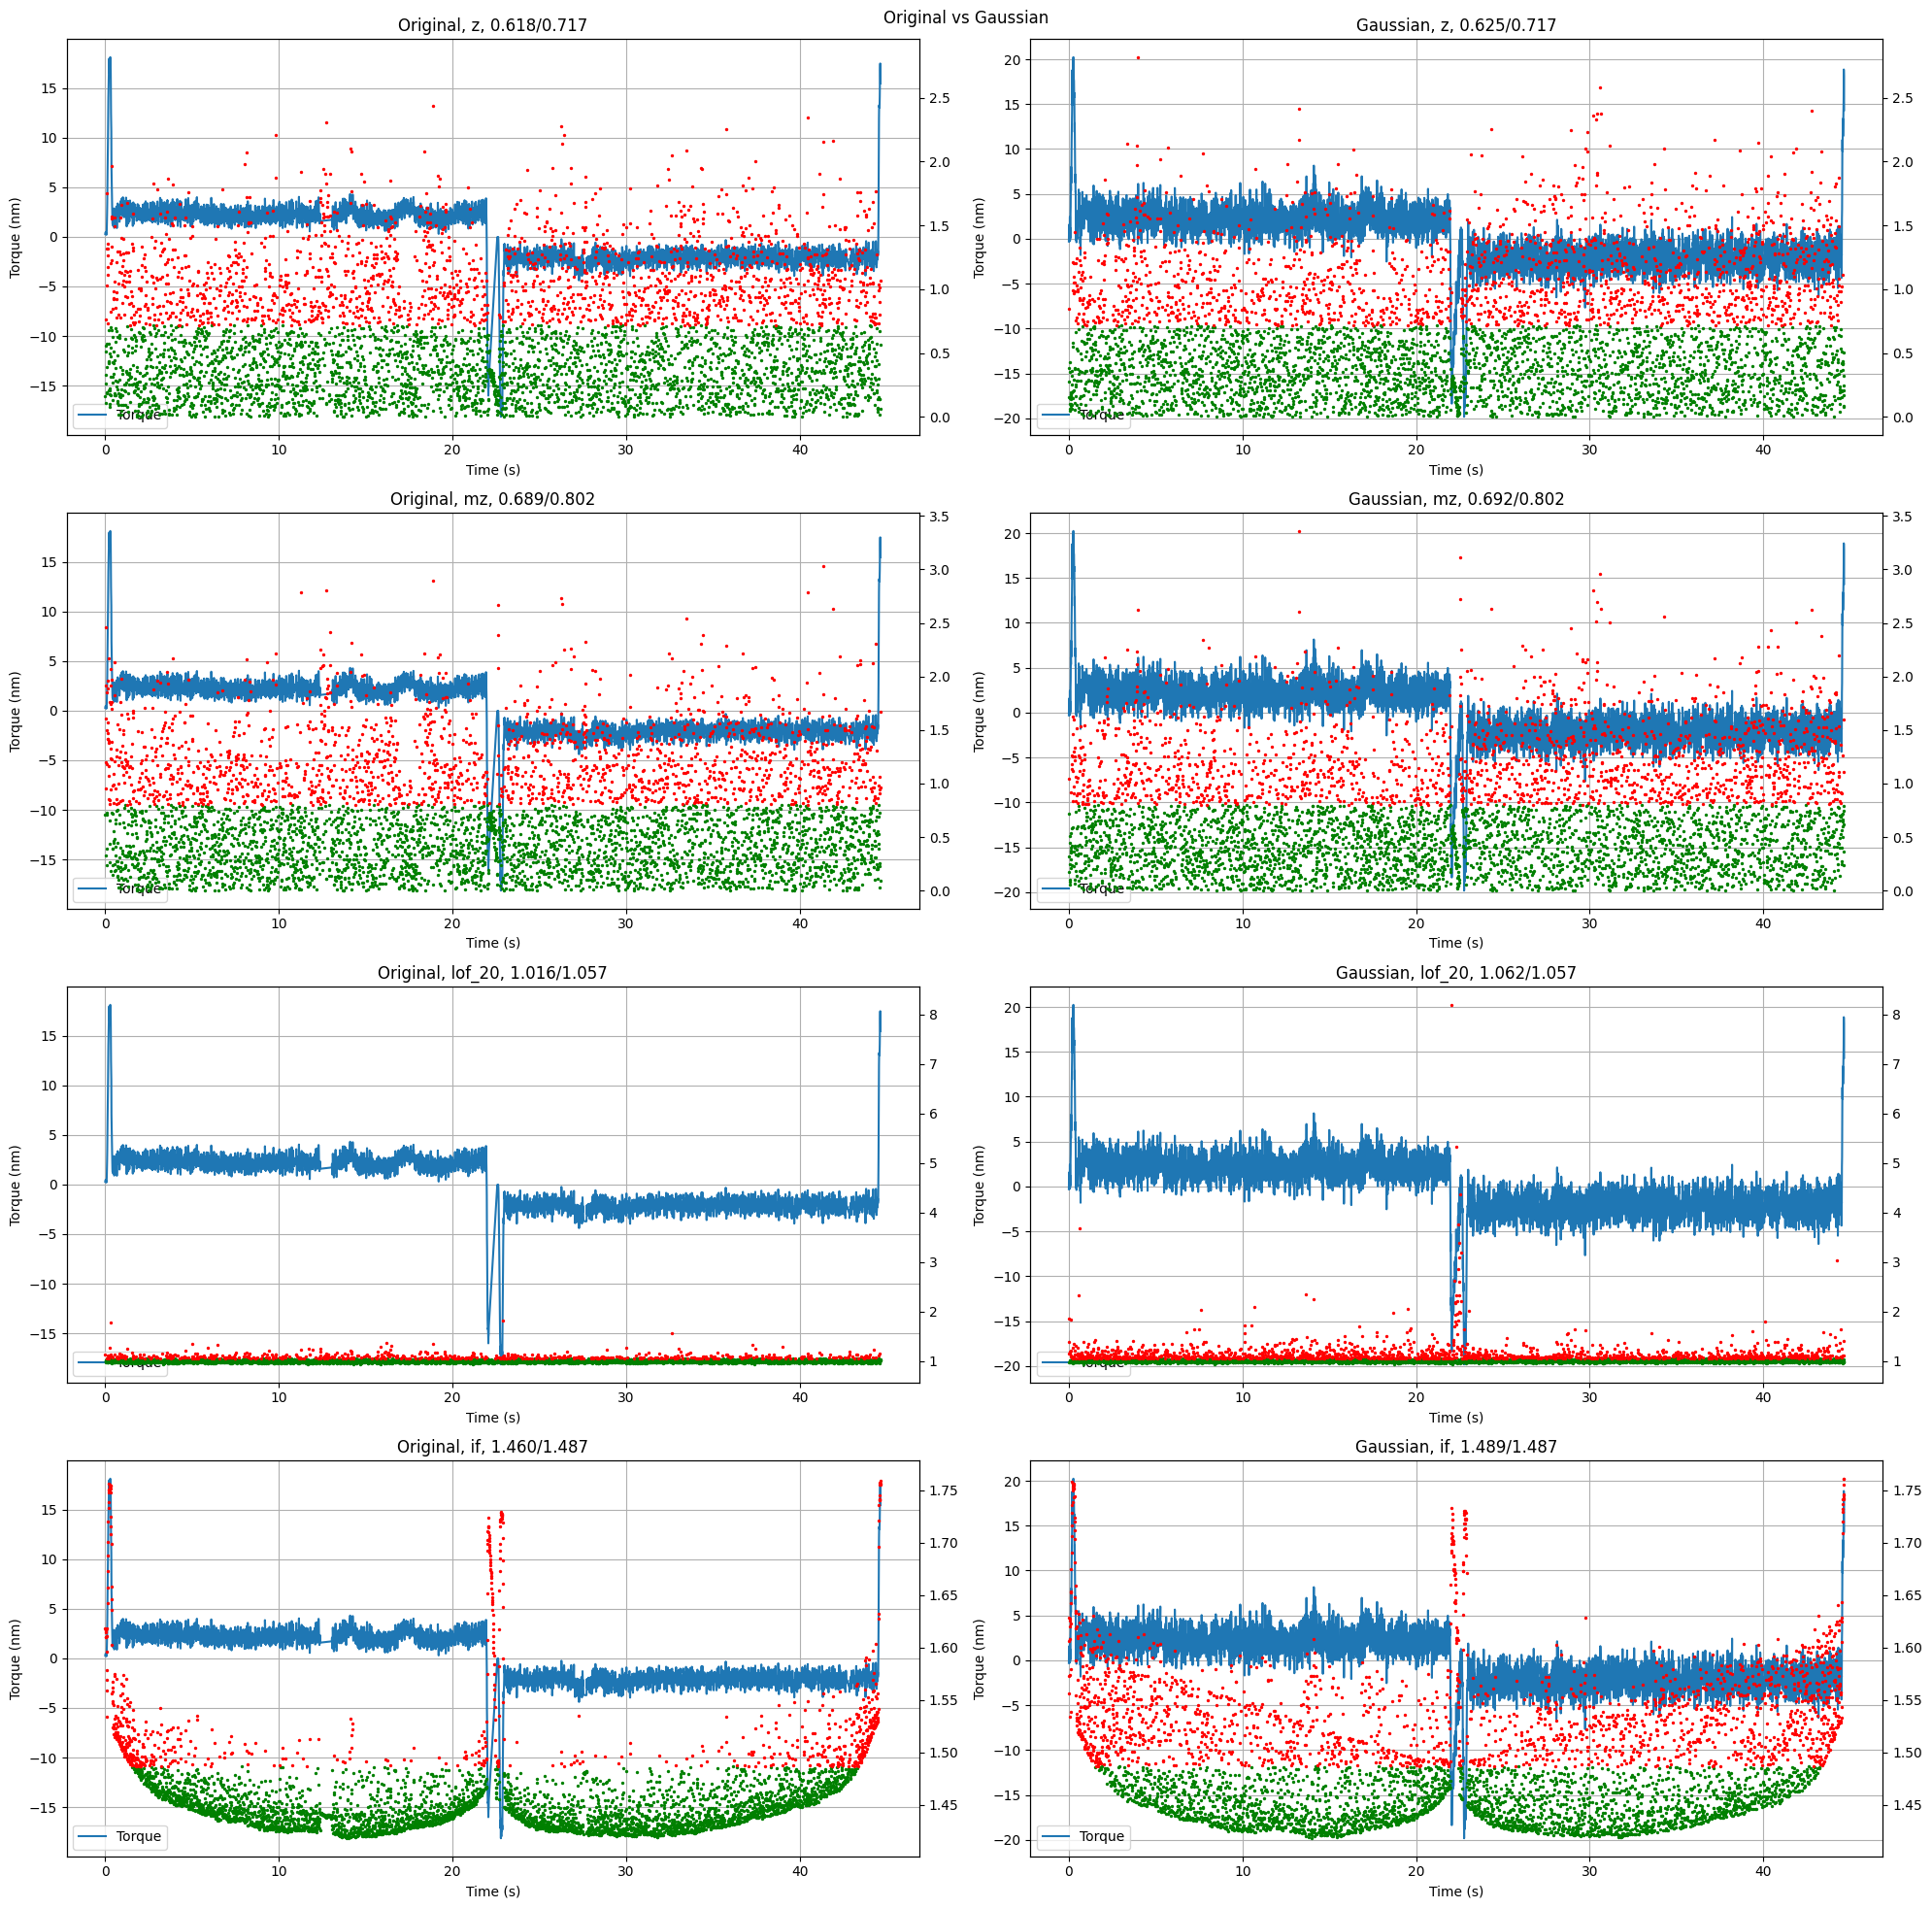

In [34]:
exp = exps_gaussian['gaussian_0.1_0.4_6640-102140-1']
exp.calculate_metrics(aggrfunc=agg.aggr_sum)

modelnames = ['z', 'mz', 'lof_20', 'if']
seqid_gauss = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'gaussian' in seqid])
seqid_org = seqid_gauss.replace("gaussian", "original")

plot_multiple2(modelnames, exp, seqid_org, seqid_gauss, syntype="Gaussian", colsize=10, rowsize=10)

z_gaussian_0.1_0.1_6640-102140-1
z, 0.1
z_gaussian_0.1_0.25_6640-102140-1
z, 0.25
z_gaussian_0.1_0.4_6640-102140-1
z, 0.4
z_gaussian_0.1_0.55_6640-102140-1
z, 0.55
mz_gaussian_0.1_0.1_6640-102140-1
mz, 0.1
mz_gaussian_0.1_0.25_6640-102140-1
mz, 0.25
mz_gaussian_0.1_0.4_6640-102140-1
mz, 0.4
mz_gaussian_0.1_0.55_6640-102140-1
mz, 0.55
lof_20_gaussian_0.1_0.1_6640-102140-1
lof_20, 0.1
lof_20_gaussian_0.1_0.25_6640-102140-1
lof_20, 0.25
lof_20_gaussian_0.1_0.4_6640-102140-1
lof_20, 0.4
lof_20_gaussian_0.1_0.55_6640-102140-1
lof_20, 0.55
if_gaussian_0.1_0.1_6640-102140-1
if, 0.1
if_gaussian_0.1_0.25_6640-102140-1
if, 0.25
if_gaussian_0.1_0.4_6640-102140-1
if, 0.4
if_gaussian_0.1_0.55_6640-102140-1
if, 0.55


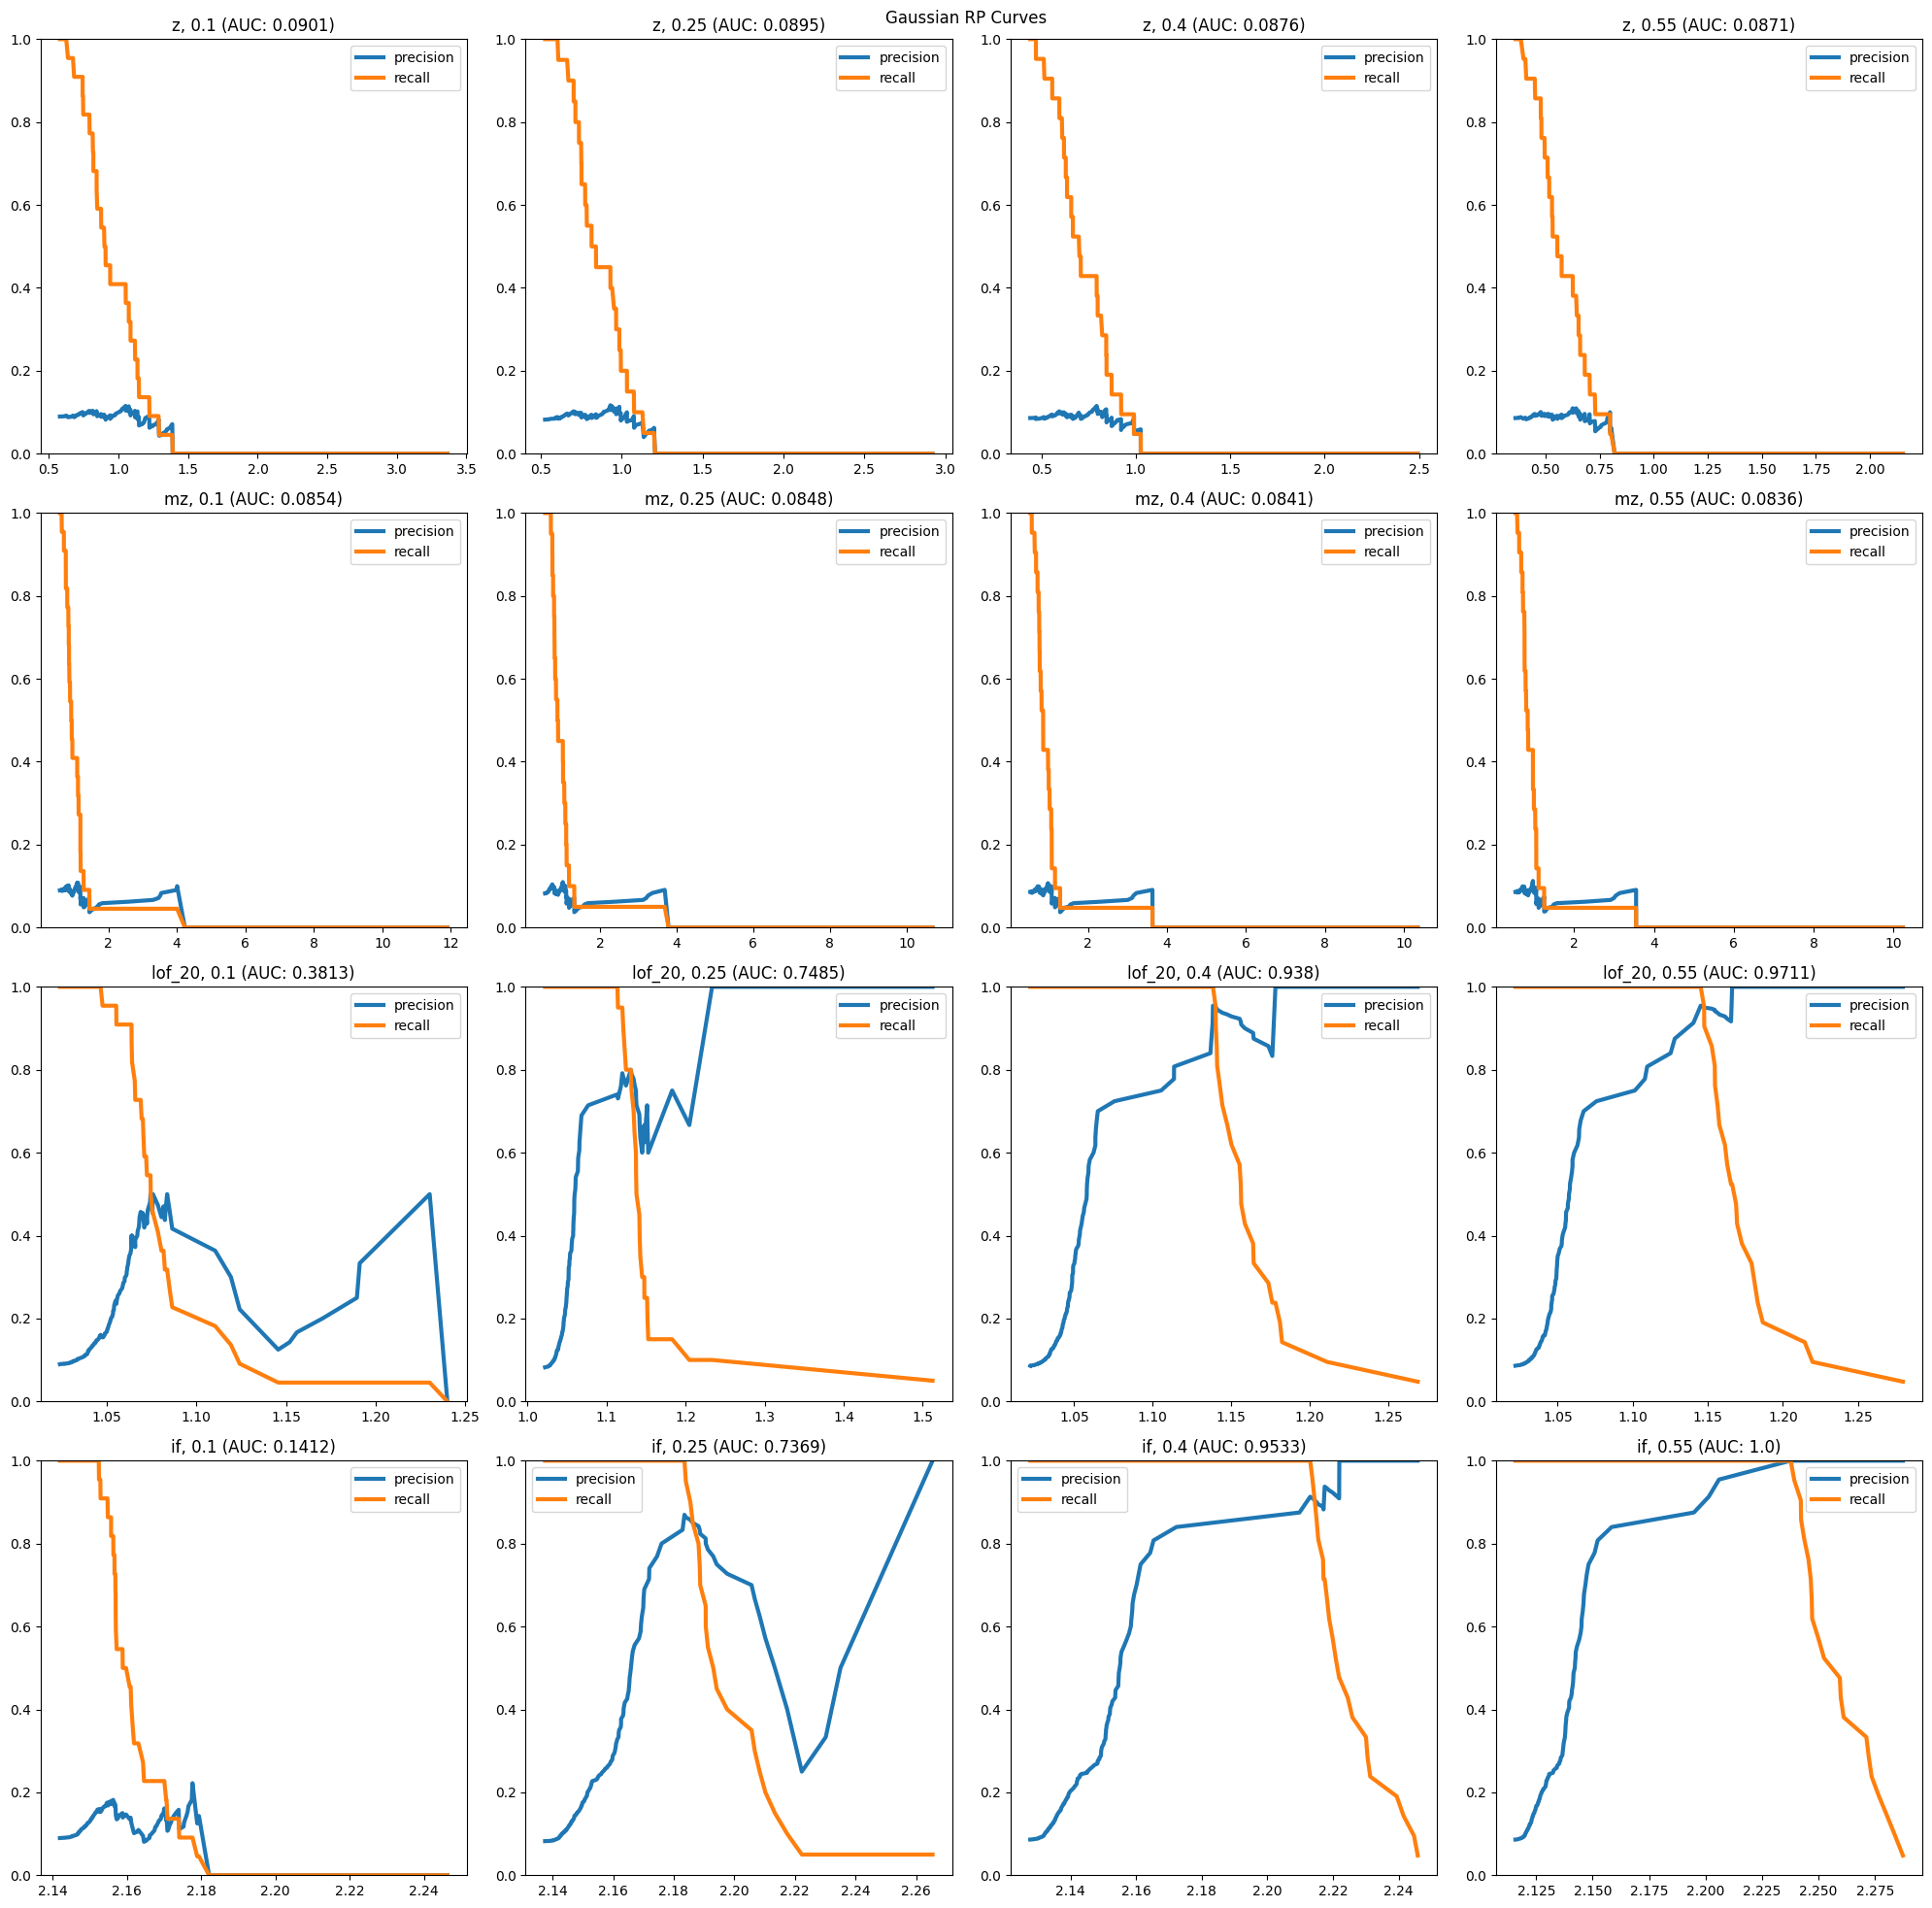

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_gaussian.items():
        xs = ename.split('_')
        rp_curves[f"{mname}, {xs[2]}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title="Gaussian RP Curves", auc=True, f1=False, linewidth=3)

# SINUSOIDAL

In [21]:
# Load or Run Experiments, depending on load_experiments
exps_sinusoidal = load_or_run_experiments(sinusoidal_params, name_sinusoidal_experiment, run_sinusoidal_experiment)


Loading Experiment sinusoidal_0.1_0.25_6640-102140-1
Loading Experiment sinusoidal_0.1_0.5_6640-102140-1
Loading Experiment sinusoidal_0.1_1_6640-102140-1
Loading Experiment sinusoidal_0.1_2_6640-102140-1
Experiments Loaded


6640-102140-1|2021-11-05|04:28:04|original 6640-102140-1|2021-11-05|04:28:04|sinus


C:\Users\Luuk Verkleij\AppData\Local\Temp\ipykernel_26928\1532158318.py:30: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


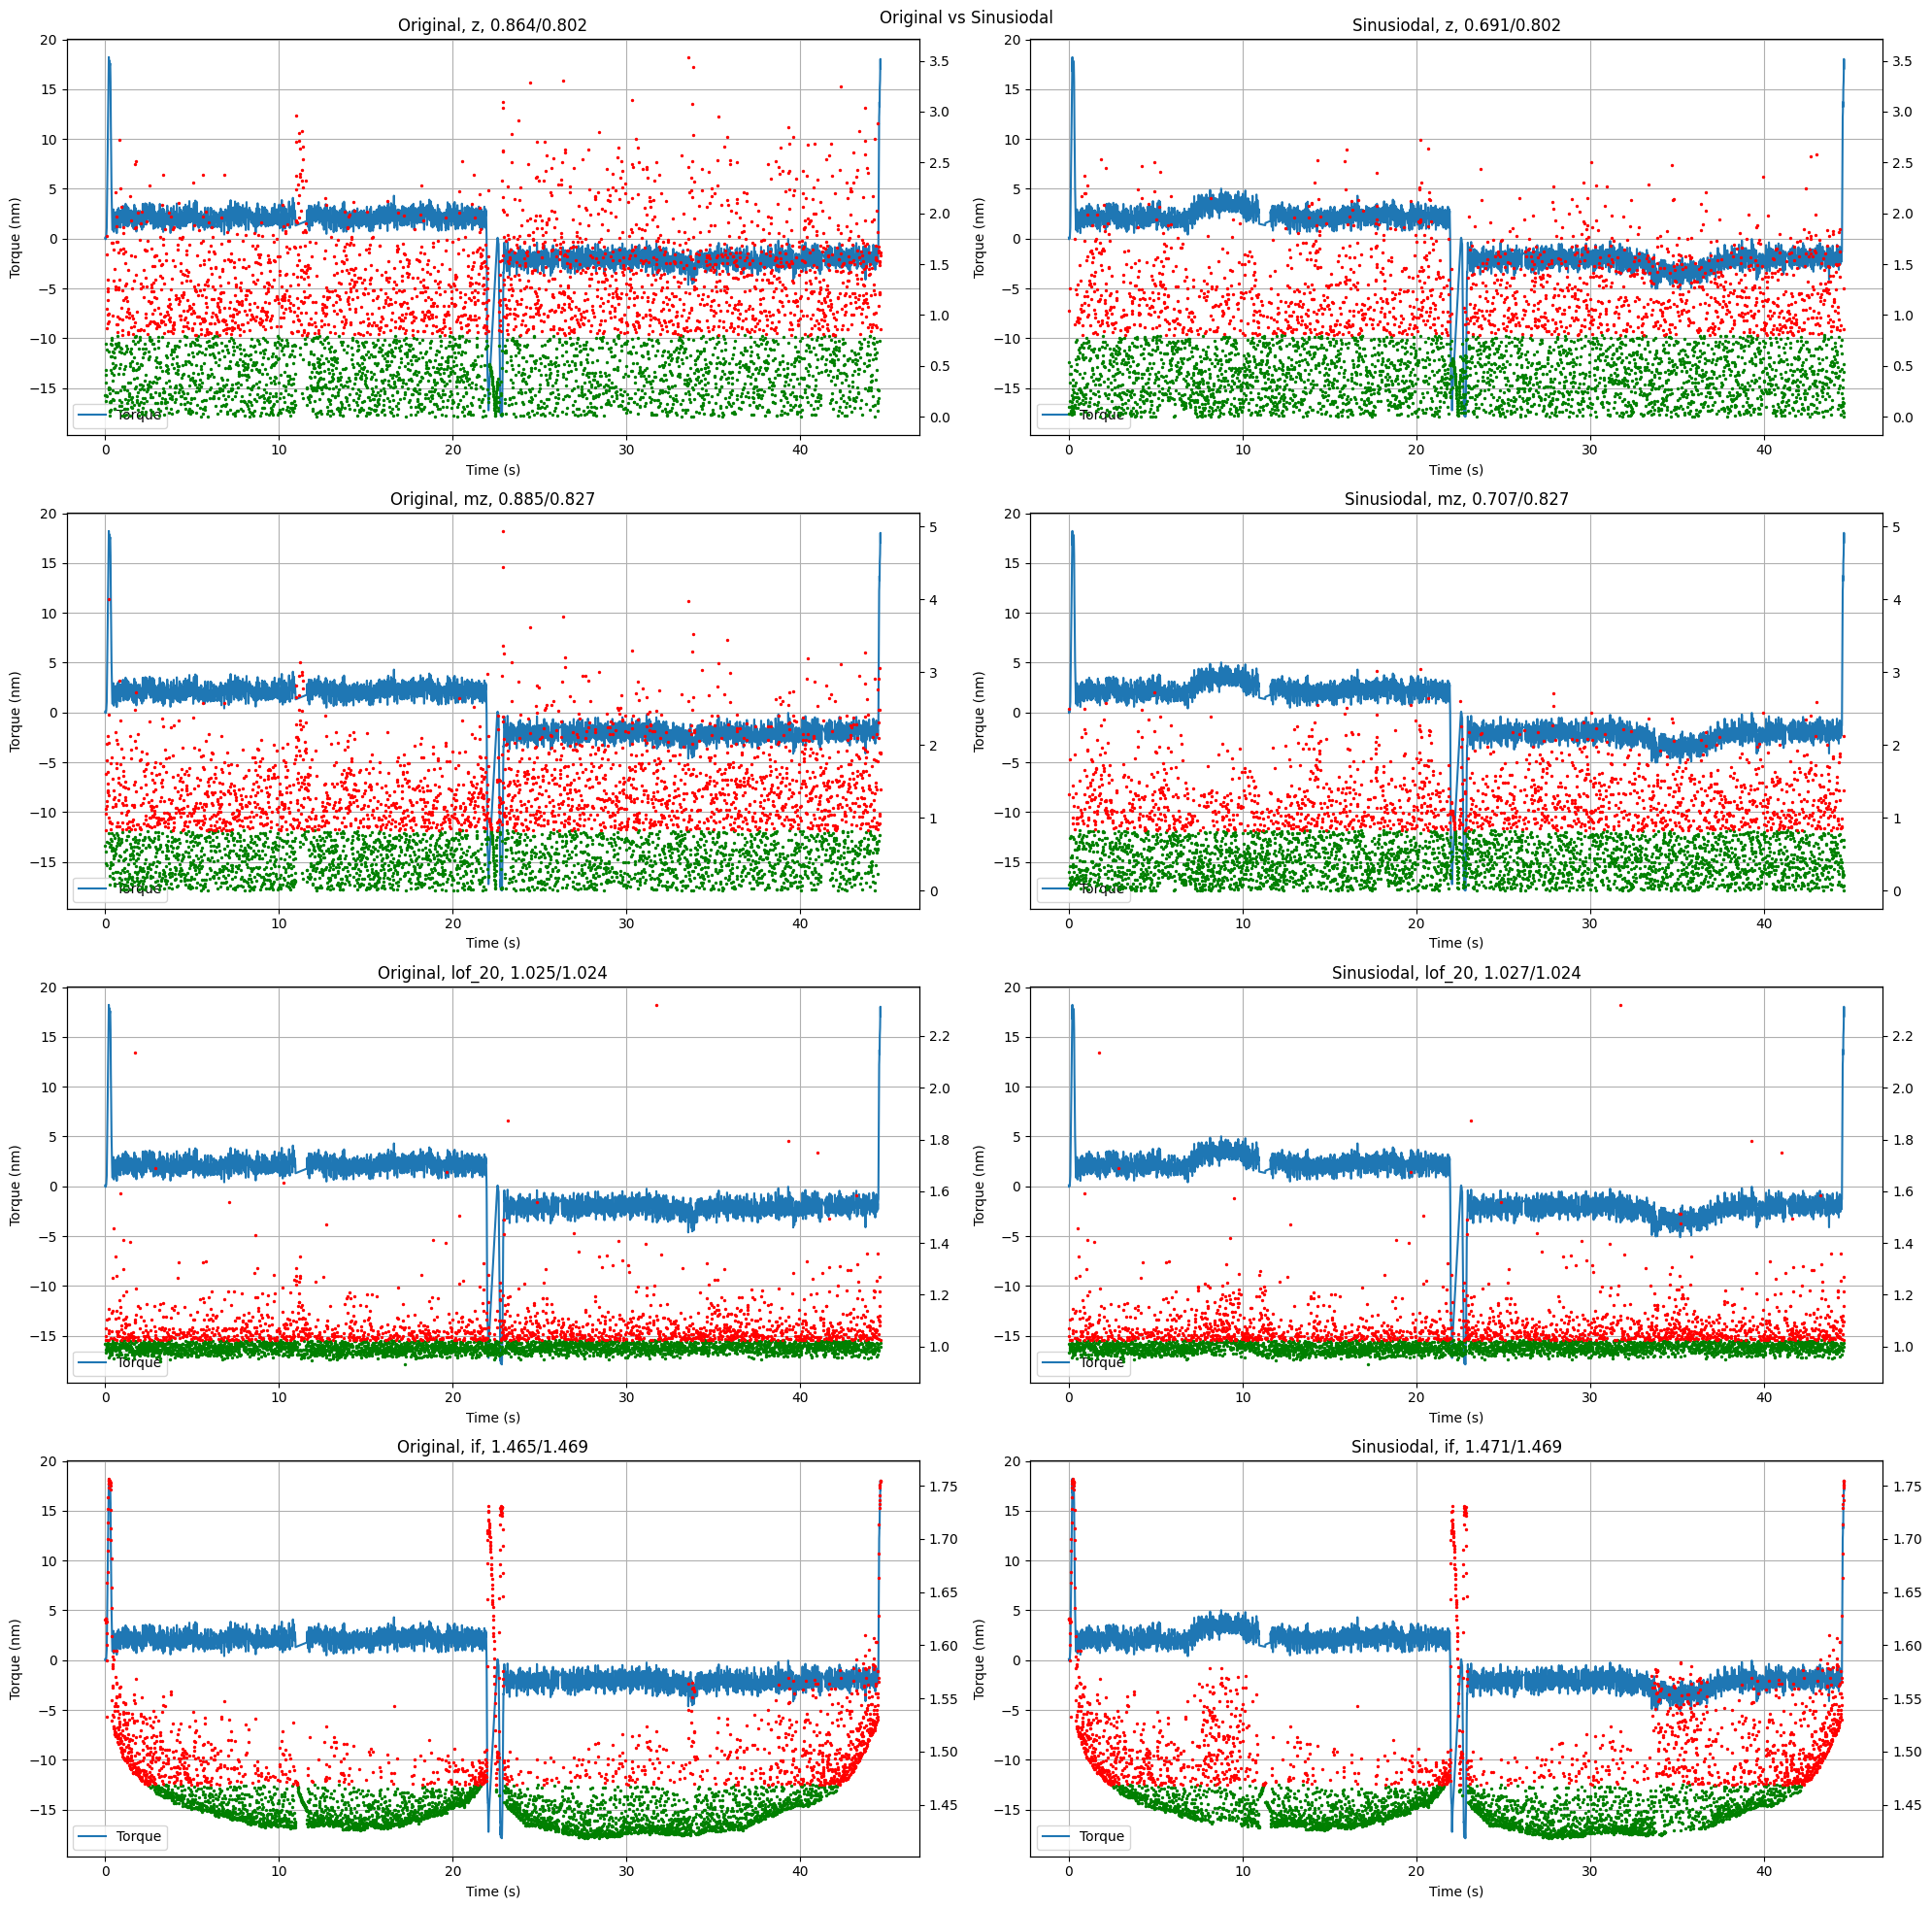

In [ ]:
exp.calculate_metrics(aggrfunc=agg.aggr_sum)

exp = exps_sinusoidal['sinusoidal_0.1_0.5_6640-102140-1']
modelnames = ['z', 'mz', 'lof_20', 'if']
seqid_sinus = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'sinus' in seqid])
seqid_org = seqid_sinus.replace("sinus", "original")

print(seqid_org, seqid_sinus)

plot_multiple2(modelnames, exp, seqid_org, seqid_sinus, syntype="Sinusiodal", colsize=10, rowsize=10)


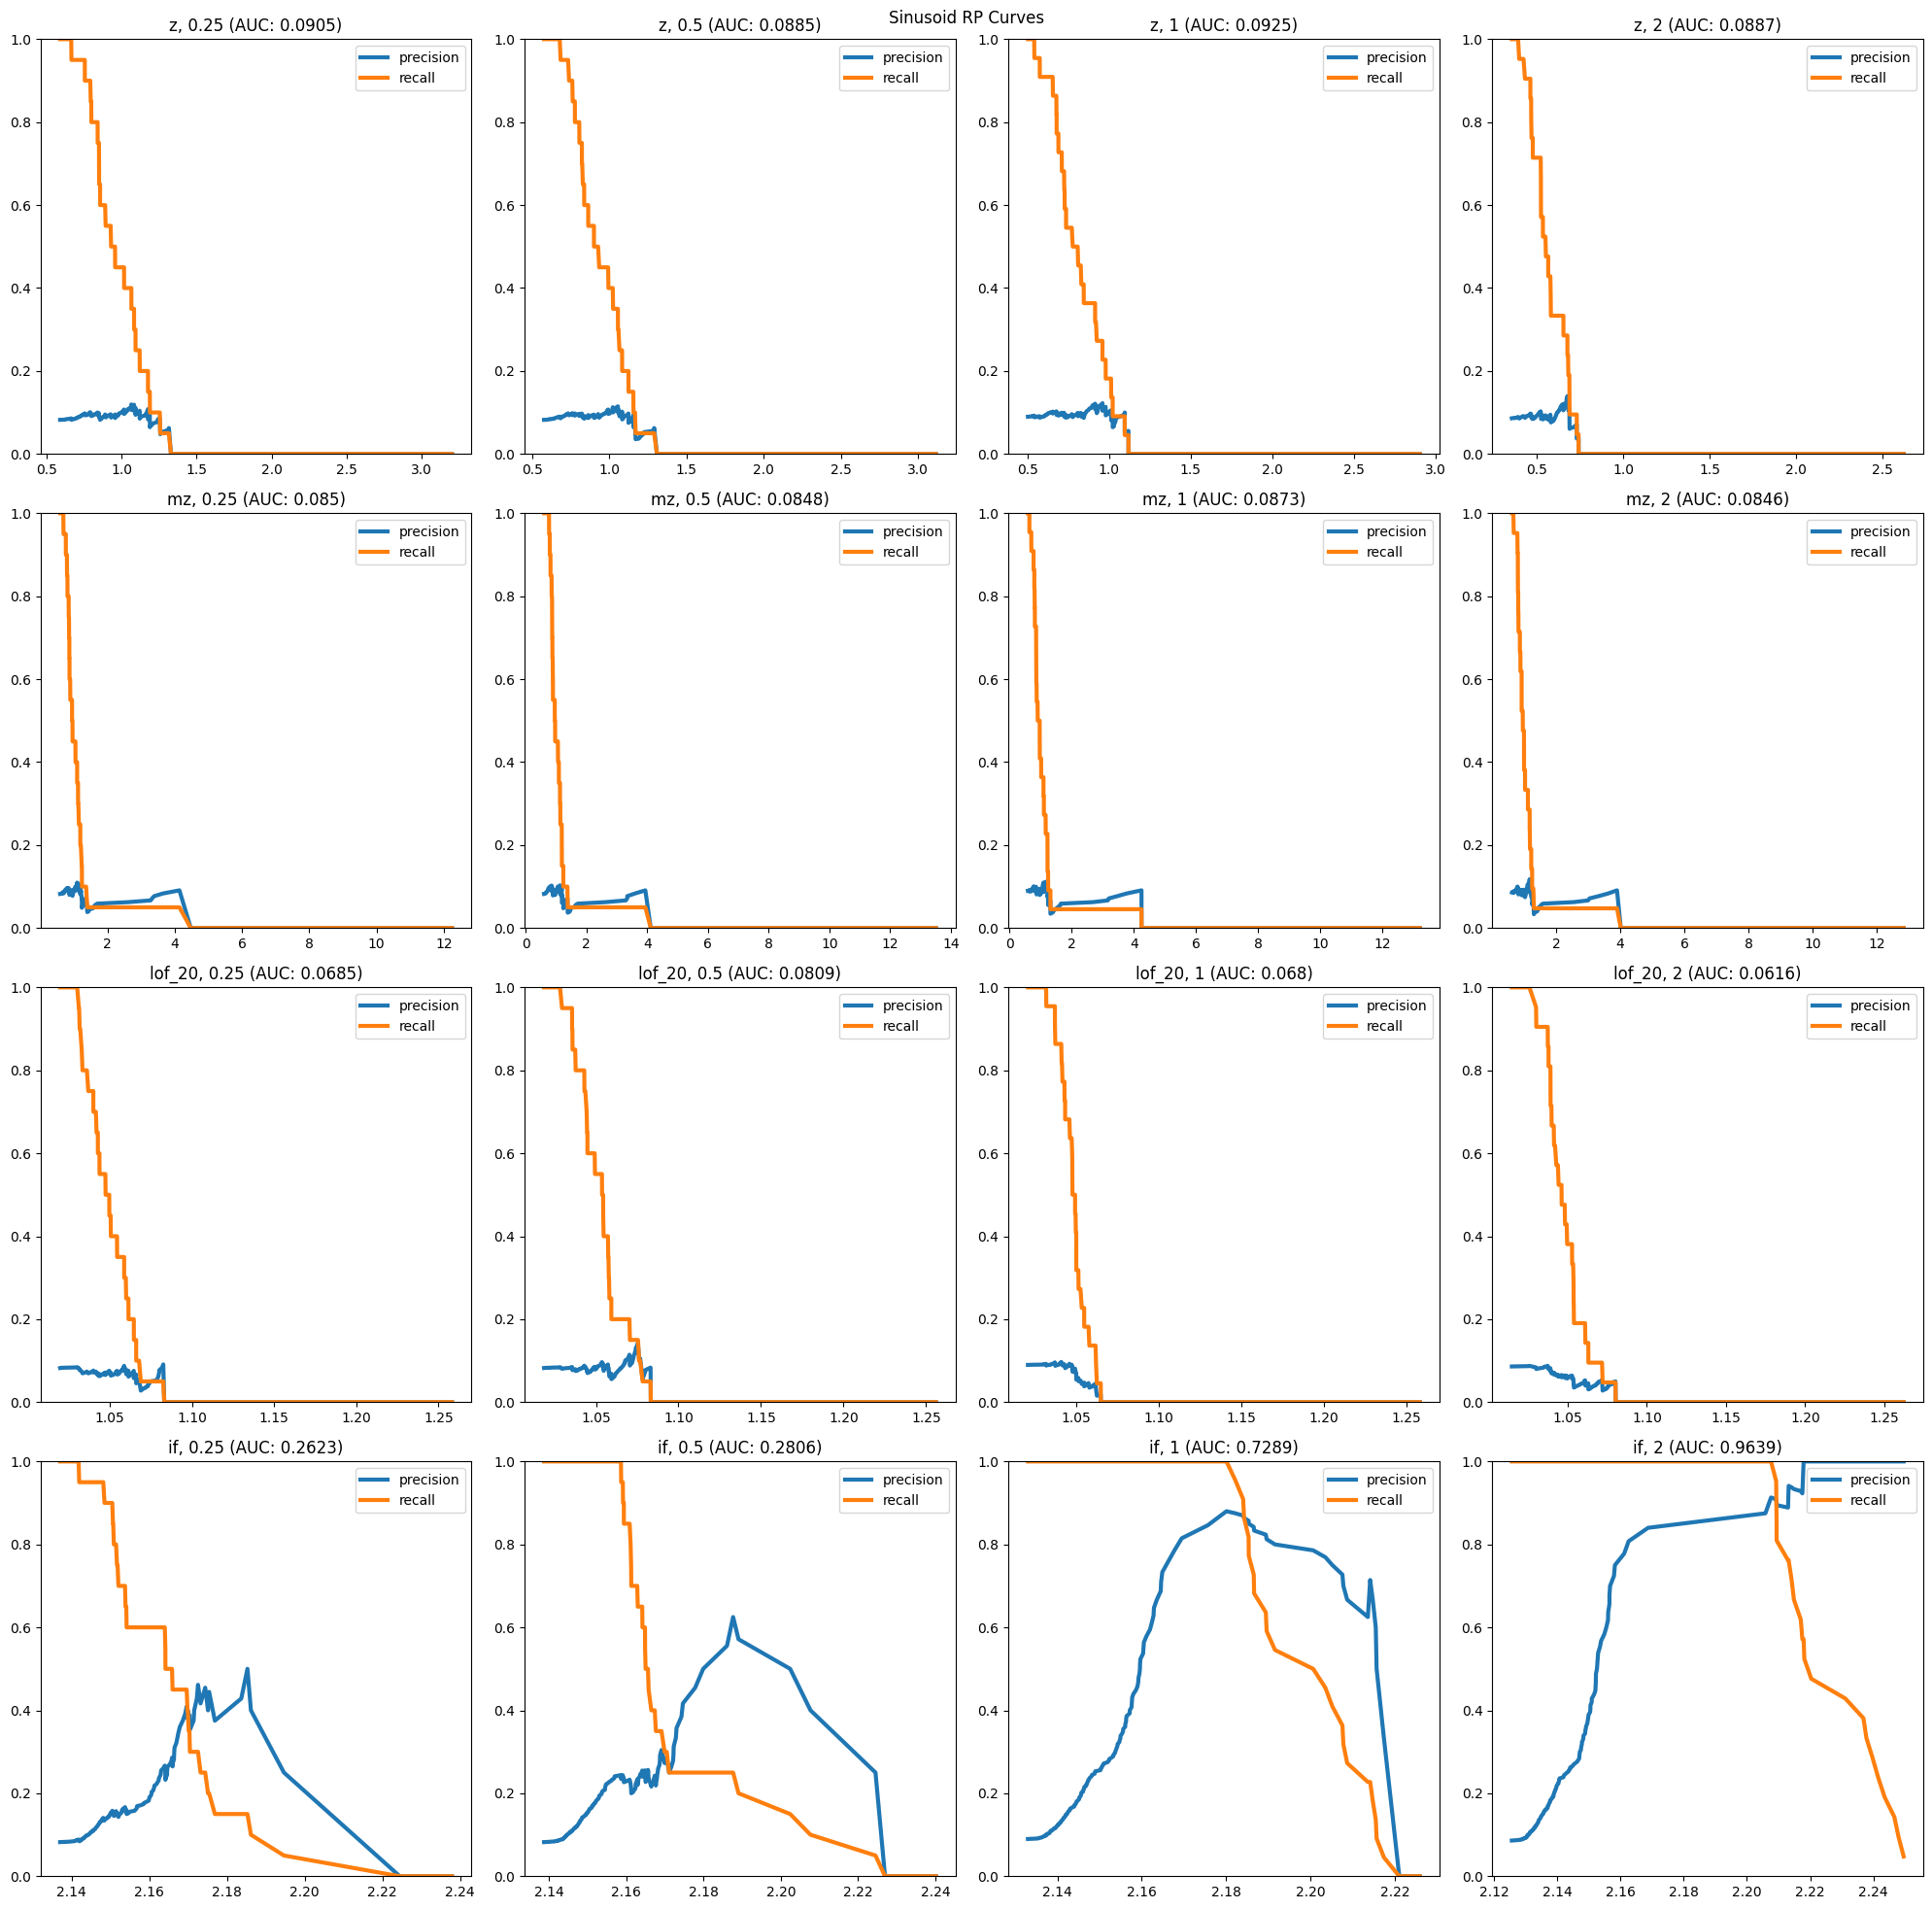

In [22]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_sinusoidal.items():
        xs = ename.split('_')
        rp_curves[f"{mname}, {xs[2]}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title="Sinusoid RP Curves", auc=True, f1=False, linewidth=3)

# POINT

In [23]:
# Load or Run Experiments, depending on load_experiments
exps_point = load_or_run_experiments(point_params, name_point_experiment, run_point_experiment)

Loading Experiment point_0.1_1_6640-102140-1
Loading Experiment point_0.1_5_6640-102140-1
Loading Experiment point_0.1_10_6640-102140-1
Loading Experiment point_0.1_100_6640-102140-1
Experiments Loaded


C:\Users\Luuk Verkleij\AppData\Local\Temp\ipykernel_26928\1203738783.py:30: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


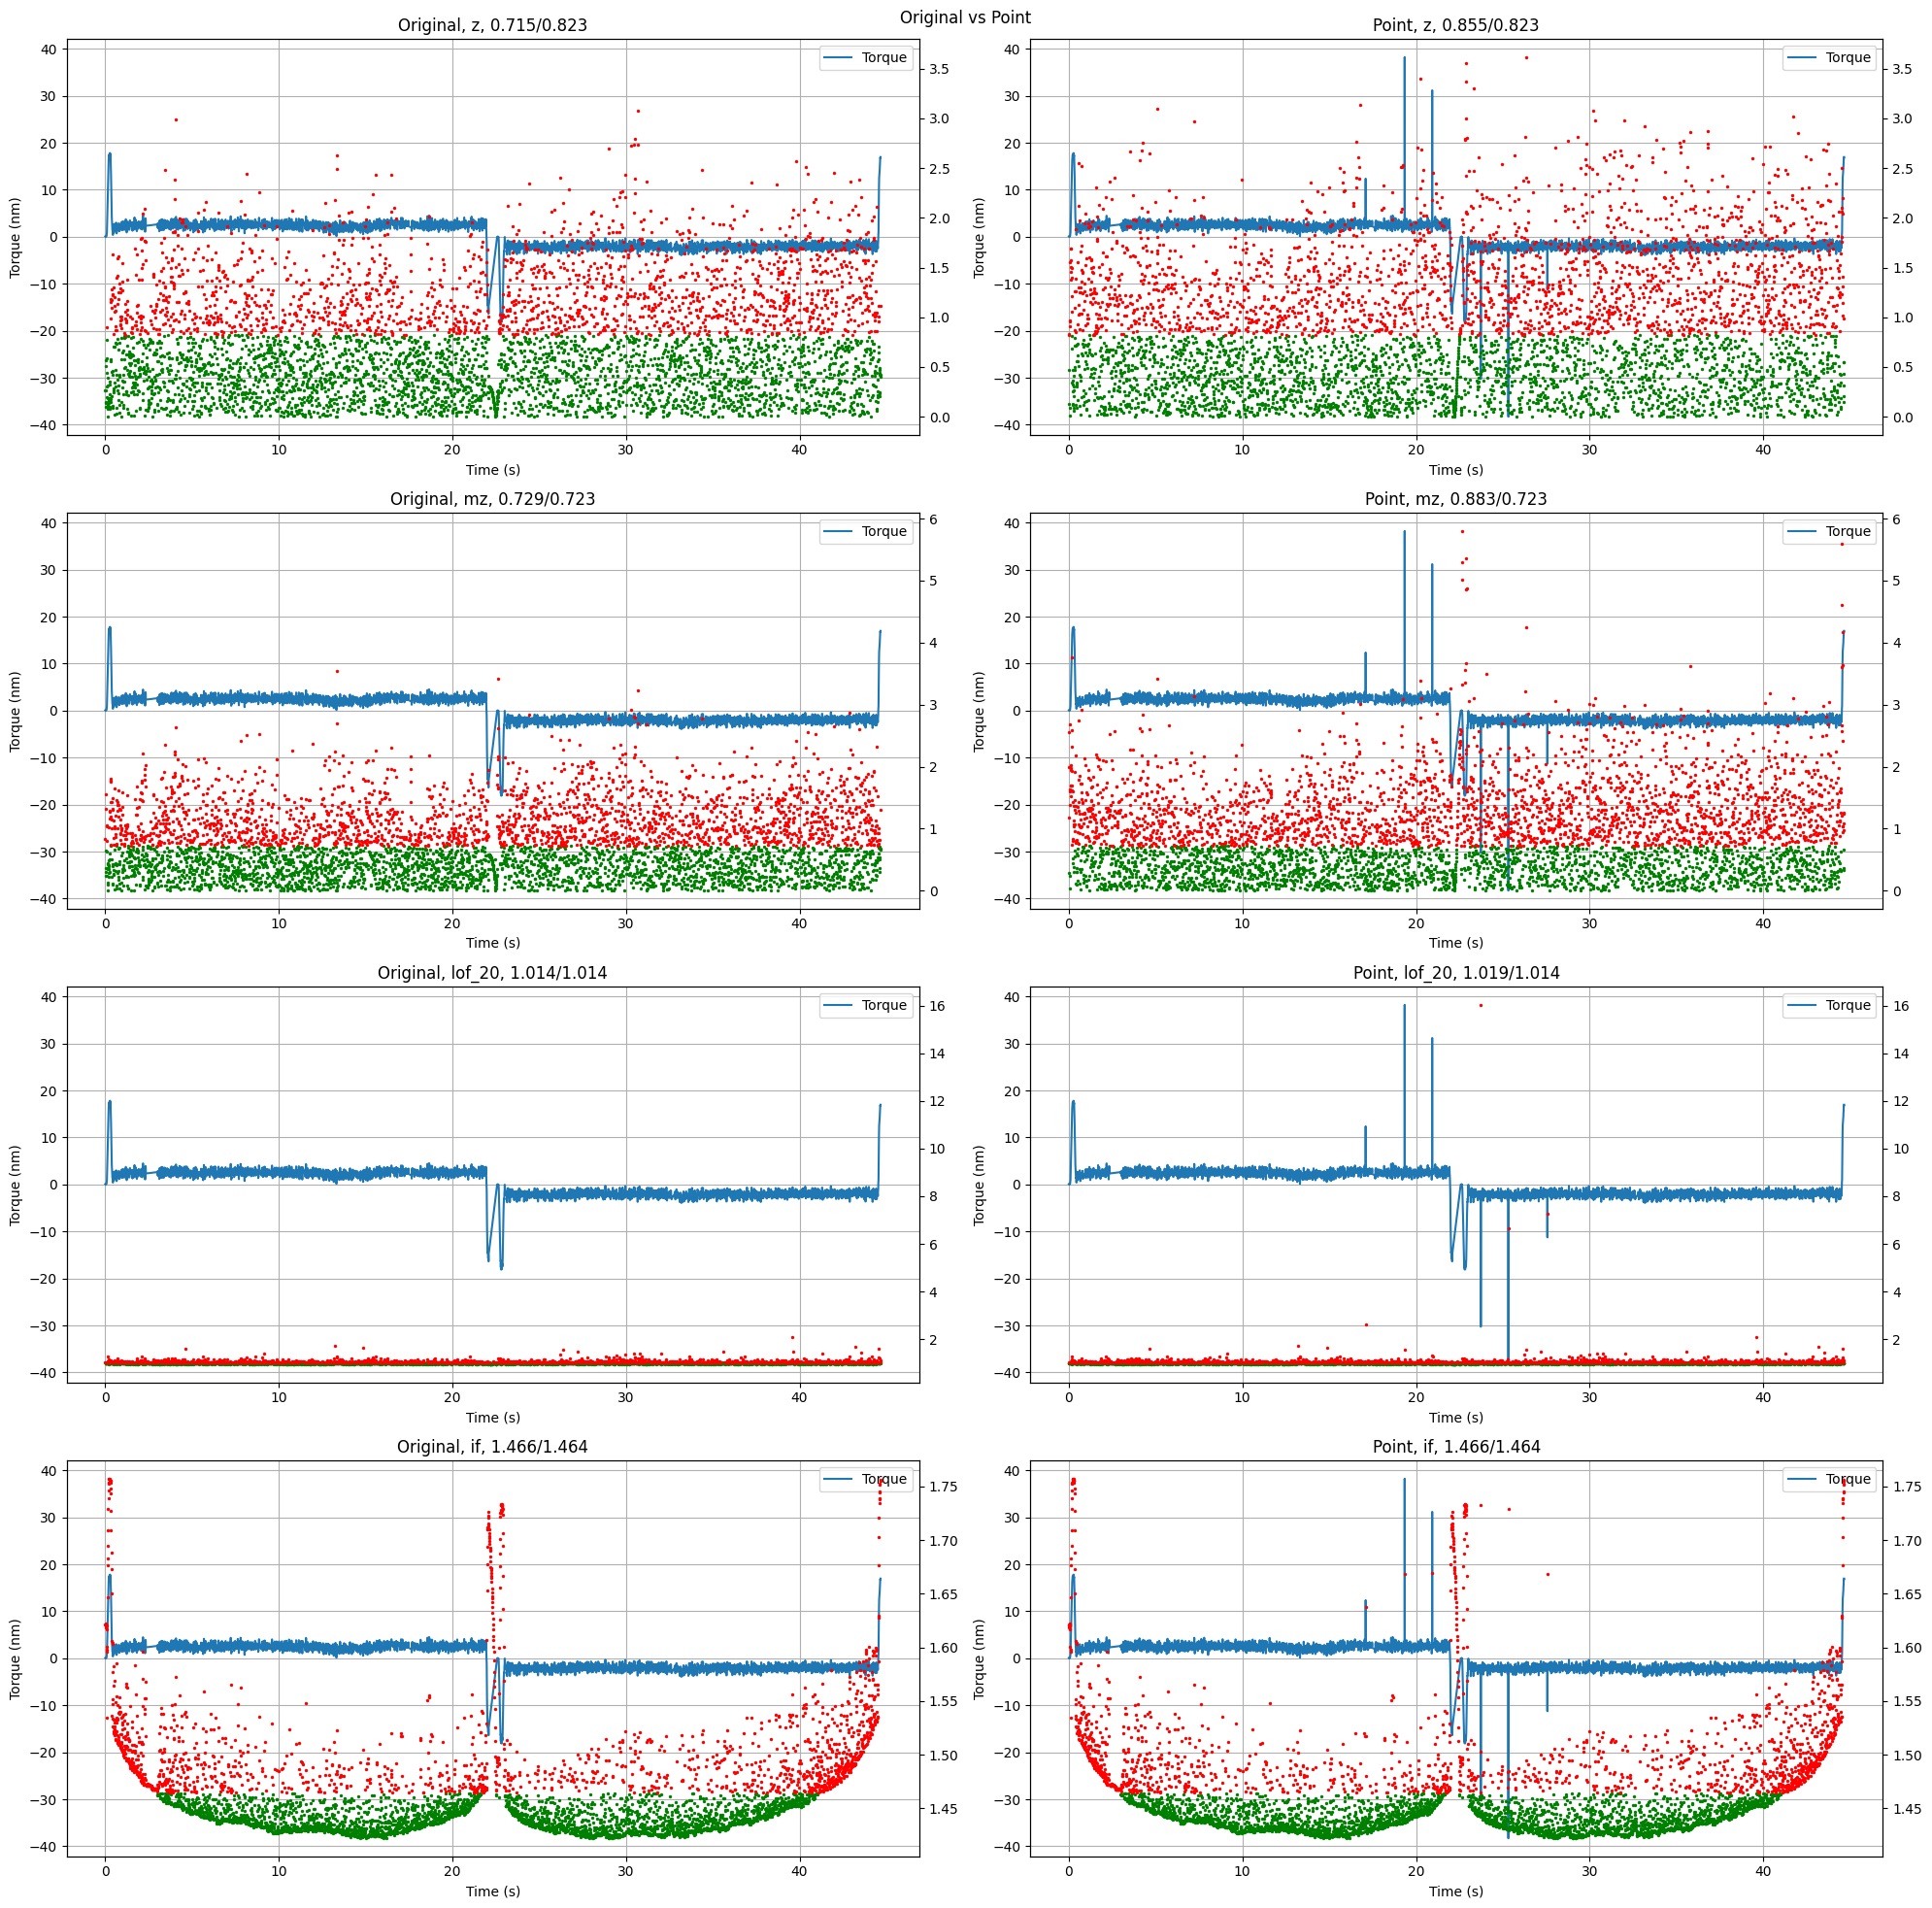

In [41]:
exp = exps_point['point_0.1_5_6640-102140-1']
exp.calculate_metrics(aggrfunc=agg.aggr_sum)

modelnames = ['z', 'mz', 'lof_20', 'if']
seqid_point = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'point' in seqid])
seqid_org = seqid_point.replace("point", "original")

plot_multiple2(modelnames, exp, seqid_org, seqid_point, syntype="Point", colsize=10, rowsize=10)

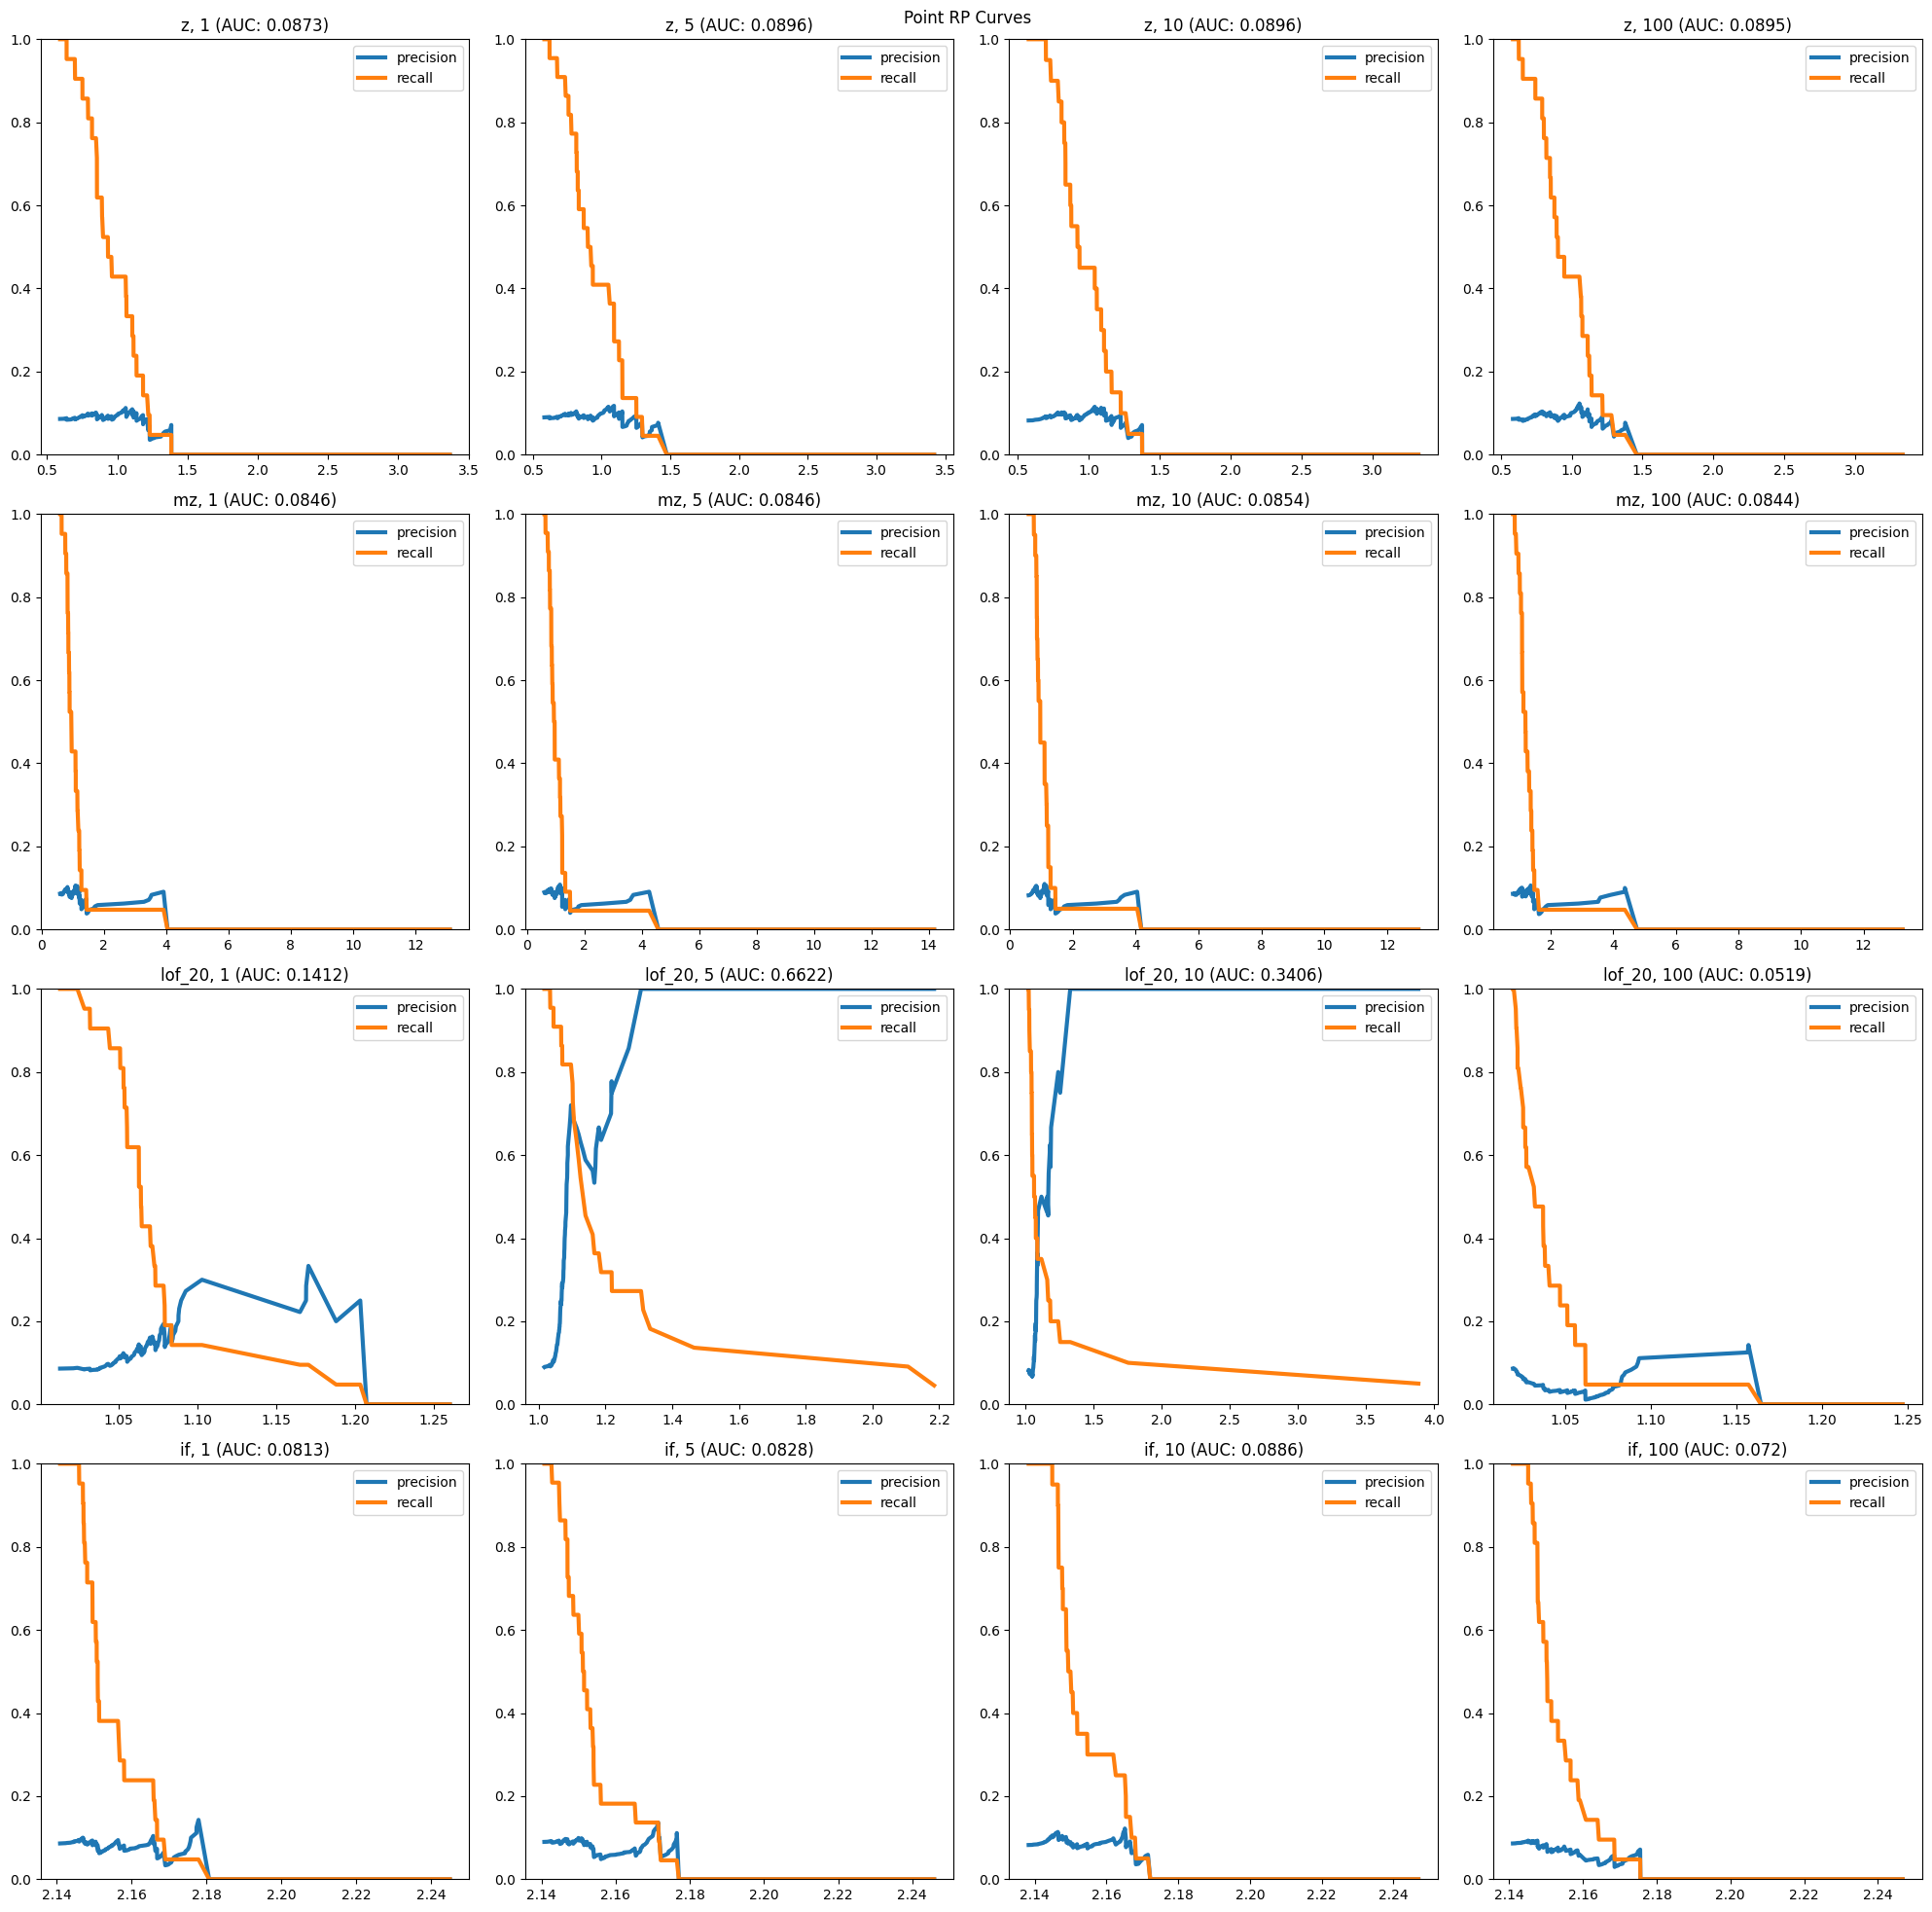

In [24]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_point.items():
        xs = ename.split('_')
        rp_curves[f"{mname}, {xs[2]}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title="Point RP Curves", auc=True, f1=False, linewidth=3)

In [ ]:
folder_path = g.experiments_folder_path

files_to_unpickle = [
    file for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file)) and file.endswith("6640-102140-1")
]

files_to_unpickle


In [ ]:
unpickled_data = {}
for file_name in files_to_unpickle:
    unpickled_data[file_name] = Experiment.unpickle(file_name)    
    
for (name, exp) in unpickled_data.items():
    print(f"{name} - {exp.results['auc-pr']}")